# Proyecto Integrador Machine Learning I
### Autores
* Marian Alejandra Sierra Aranzazu
* Jorge Erick Vasquez Martinez

# Contextualizacion del problema
* Problema:  Las tiendas en línea necesitan conocer a sus clientes para mejorar estrategias de retención, personalización de ofertas y previsión de ingresos
* Motivacion: Mejorar el valor de vida del cliente (CLV), reducir churn y aumentar ventas personalizadas.
* Usos: Fundamental para marketing dirigido, logística de inventario y diseño de campañas.
* Dataset: https://archive.ics.uci.edu/dataset/352/online+retail

# Exploracion y procesamiento

### Librerias

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.linear_model import Ridge
import lightgbm as lgb
import warnings
import matplotlib.dates as mdates
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.linear_model import LinearRegression


warnings.filterwarnings("ignore")

In [34]:
# Función para identificar y visualizar valores nulos en un DataFrame
def missing_data(df):
    # Total de valores nulos por columna, ordenados de mayor a menor
    total = df.isnull().sum().sort_values(ascending=False)
    
    # Porcentaje de valores nulos por columna
    percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
    
    # Combina el total y el porcentaje en un único DataFrame
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

    # Retorna el resumen de valores nulos
    return missing_data


### EDA

In [35]:
# Lectura del archivo Excel original con datos de ventas
df = pd.read_excel('Online Retail.xlsx')

In [36]:
# Vista previa de las primeras 5 filas del DataFrame
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [37]:
# Obtener la cantidad total de registros del DataFrame
len(df)

541909

In [38]:
# Aplicar función para identificar valores faltantes (missing values)
missing_data(df)

,Total,Percent
CustomerID,135080,0.249267
Description,1454,0.002683
StockCode,0,0.000000
InvoiceNo,0,0.000000
Quantity,0,0.000000
InvoiceDate,0,0.000000
UnitPrice,0,0.000000
Country,0,0.000000


* 2% of the descriptions are null but this is not a blocker becuase we have the StockCode
* 24% of the Customer ID are nulls, we'll be deleting this records, we have enough data.

In [39]:
# Mostrar un resumen estadístico de las variables numéricas del dataframe
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [40]:
# Convertir la columna 'Country' al tipo categórico para optimizar memoria y facilitar análisis
df['Country'] = df['Country'].astype('category')

In [41]:
# Filtrar el dataframe para conservar solo las filas donde 'CustomerID' no sea nulo
df = df[df['CustomerID'].notnull()]

In [42]:
# Mostrar el número de ocurrencias de cada código de producto
display(df['StockCode'].value_counts())

StockCode
85123A    2077
22423     1905
85099B    1662
84879     1418
47566     1416
          ... 
85023C       1
35597A       1
16169N       1
90065B       1
90162A       1
Name: count, Length: 3684, dtype: int64

### Top Products

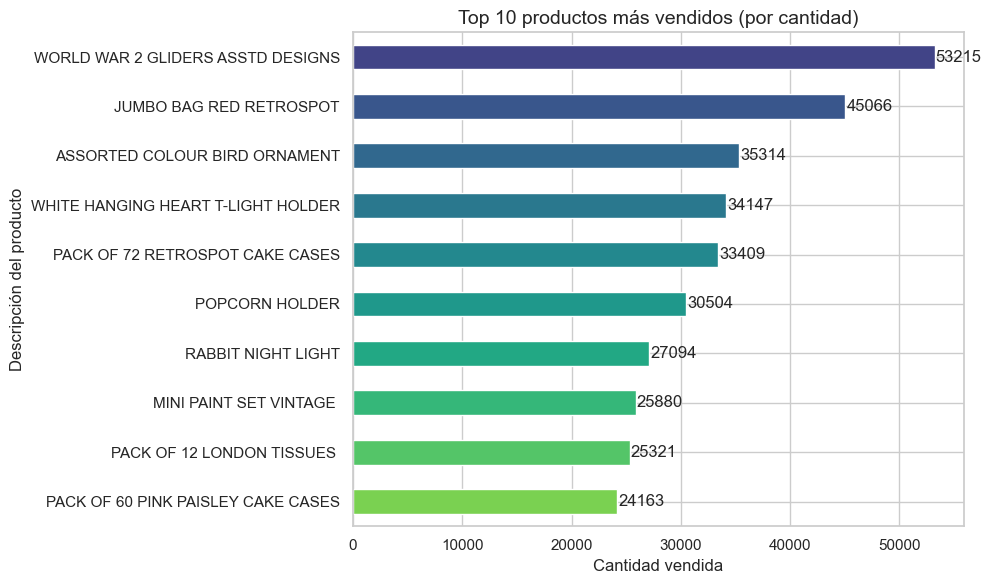

In [ ]:
# Agrupar por descripción del producto y sumar cantidades
top_products = df.groupby('Description')['Quantity'].sum()

# Ordenar de mayor a menor y quedarnos con los 10 más vendidos
top_products = top_products.sort_values(ascending=False).head(10)

# Crear figura
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar con barras horizontales, usando un colormap más amigable
top_products.plot(kind='barh', ax=ax, color=plt.cm.viridis(np.linspace(0.2, 0.8, 10)))

# Agregar etiquetas numéricas al final de cada barra
for i, value in enumerate(top_products):
    ax.text(value + 100, i, str(int(value)), va='center')

# Invertir eje Y para que el producto más vendido esté arriba
ax.invert_yaxis()

# Títulos y etiquetas
ax.set_title('Top 10 productos más vendidos (por cantidad)', fontsize=14)
ax.set_xlabel('Cantidad vendida')
ax.set_ylabel('Descripción del producto')

# Ajustar márgenes
plt.tight_layout()
plt.show()

### Top Clientes

C:\Users\maria\AppData\Local\Temp\ipykernel_34940\673157047.py:34: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\maria\OneDrive\Escritorio\proyecto_integrador_ml\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


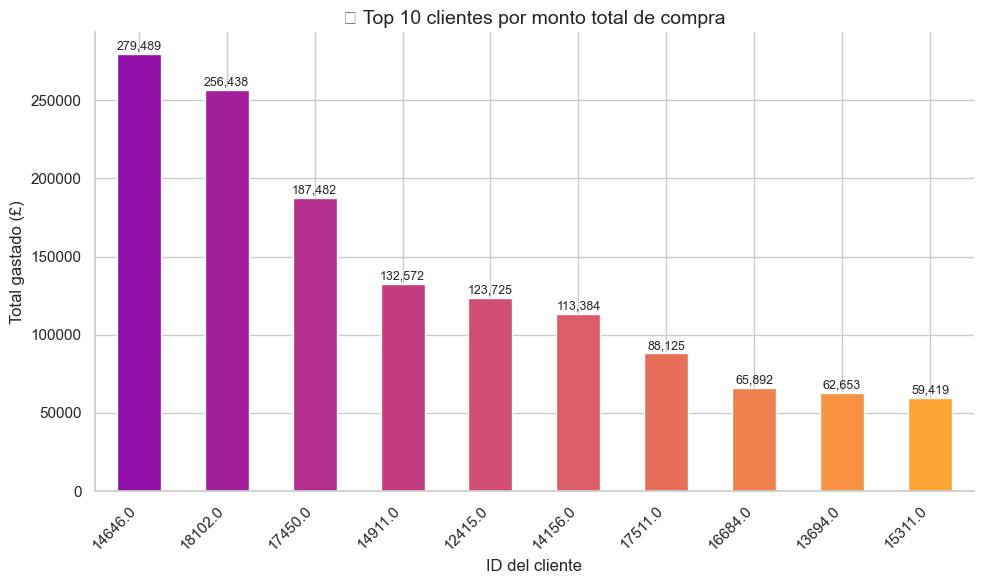

In [ ]:
# Crear una nueva columna que representa el valor total por línea de producto
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Agrupar por CustomerID y sumar TotalPrice para obtener el gasto total por cliente
top_customers = df.groupby('CustomerID')['TotalPrice'].sum()

# Ordenar y seleccionar los 10 mejores clientes por gasto total
top_customers = top_customers.sort_values(ascending=False).head(10)

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar en barras con colores personalizados
top_customers.plot(kind='bar', ax=ax, color=plt.cm.plasma(np.linspace(0.3, 0.8, 10)))

# Agregar valores numéricos encima de cada barra
for idx, value in enumerate(top_customers):
    ax.text(idx, value + 3000, f'{int(value):,}', ha='center', fontsize=9)

# Títulos y etiquetas
ax.set_title('Top 10 clientes por monto total de compra', fontsize=14)
ax.set_ylabel('Total gastado (£)')
ax.set_xlabel('ID del cliente')

# Mejora visual del eje X
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Quitar bordes innecesarios y ajustar layout
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


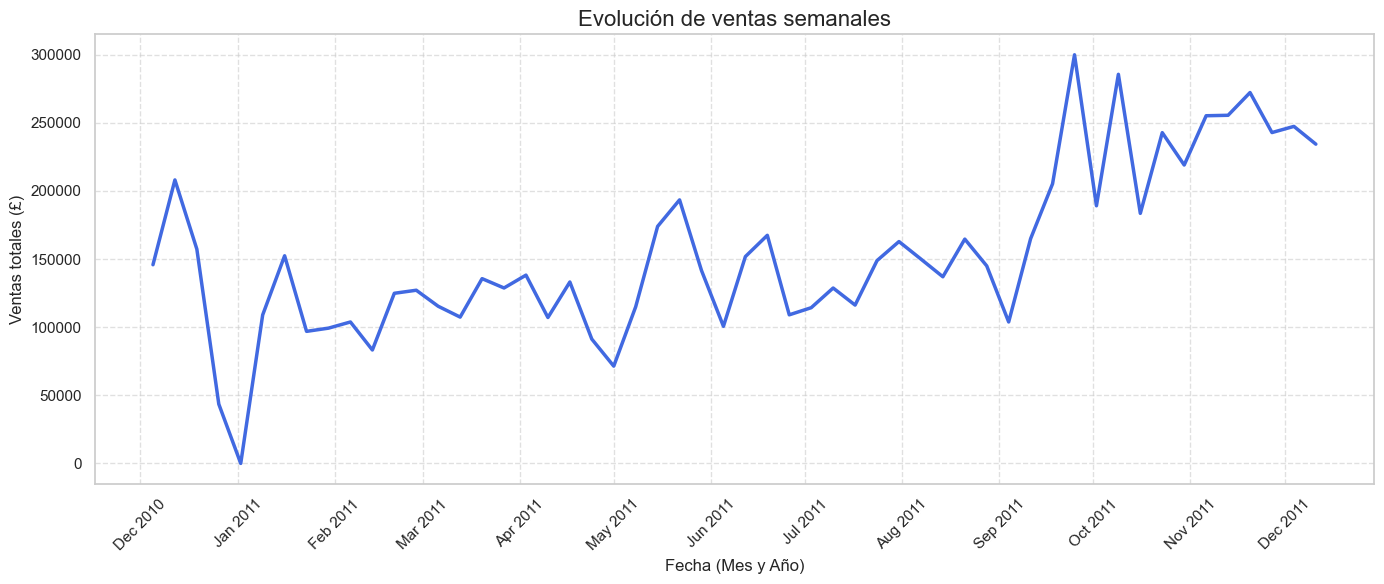

In [ ]:
# Asegurarse de que las fechas estén en formato datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calcular el monto total por transacción
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Agrupar ventas por semana
weekly_sales = df.set_index('InvoiceDate')['TotalPrice'].resample('W').sum()

# Crear la figura
plt.figure(figsize=(14, 6))
sns.lineplot(data=weekly_sales, color='royalblue', linewidth=2.5)

# Formato del eje X con meses y años
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  

# Estética del gráfico
plt.title('Evolución de ventas semanales', fontsize=16)
plt.xlabel('Fecha (Mes y Año)', fontsize=12)
plt.ylabel('Ventas totales (£)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Rotar etiquetas del eje X para mayor legibilidad
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### Chequear Outliers

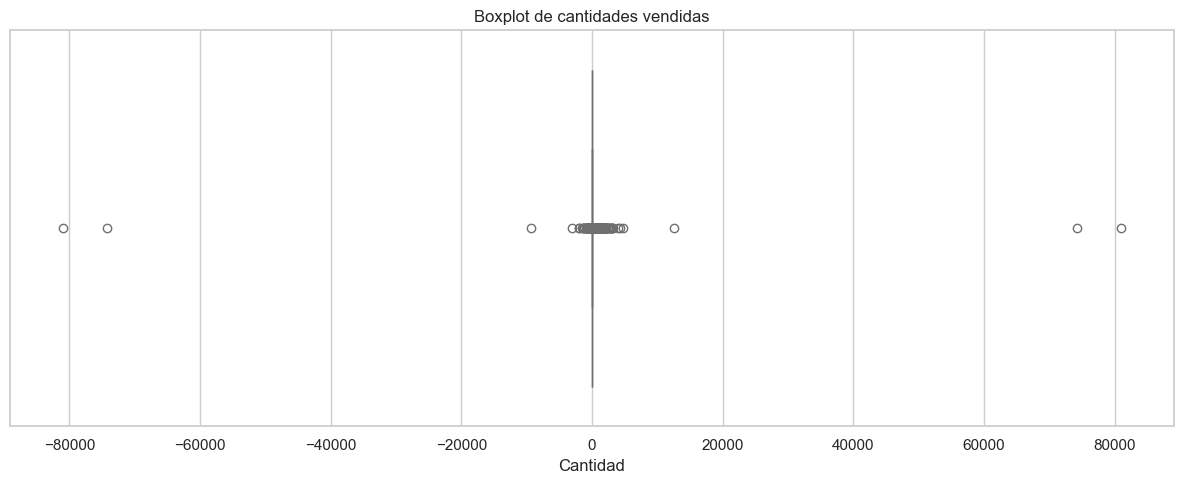

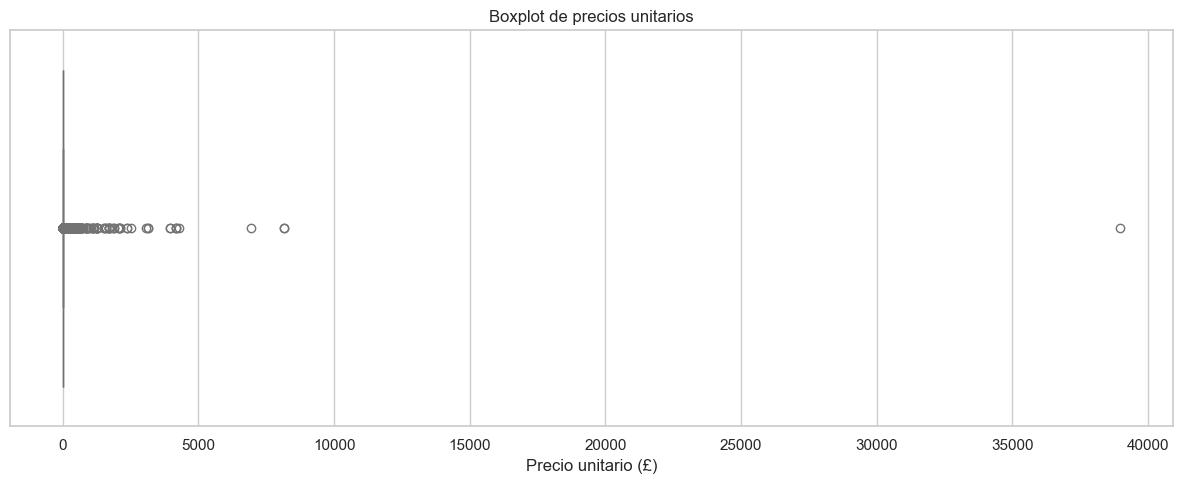

In [ ]:
# Establecer estilo visual de Seaborn para mejor apariencia
sns.set(style="whitegrid")

# -------------------------------
# Boxplot para la variable 'Quantity'
# Este gráfico nos permite ver la distribución y detectar valores atípicos (outliers) en las cantidades vendidas.
# -------------------------------
plt.figure(figsize=(12, 5))
sns.boxplot(x=df['Quantity'], color='skyblue')
plt.title('Boxplot de cantidades vendidas')
plt.xlabel('Cantidad')
plt.tight_layout()
plt.show()

# -------------------------------
# Boxplot para la variable 'UnitPrice'
# Aquí identificamos precios unitarios fuera de lo común que podrían representar errores o productos premium.
# -------------------------------
plt.figure(figsize=(12, 5))
sns.boxplot(x=df['UnitPrice'], color='lightgreen')
plt.title('Boxplot de precios unitarios')
plt.xlabel('Precio unitario (£)')
plt.tight_layout()
plt.show()


Tratamiento de outliers

In [ ]:

# Definir los percentiles para identificar outliers
# Se eliminan los valores fuera del rango del 1% al 99% para las variables 'Quantity' y 'UnitPrice'
# Percentiles más estrictos para 'Quantity'
q_low = df['Quantity'].quantile(0.01)
q_high = df['Quantity'].quantile(0.99)

# Percentiles más estrictos para 'UnitPrice'
p_low = df['UnitPrice'].quantile(0.01)
p_high = df['UnitPrice'].quantile(0.99)

# Filtrar valores fuera del rango aceptado (outliers)
# Se conservan solo los registros cuyas cantidades y precios estén dentro del nuevo rango
df = df[(df['Quantity'] >= q_low) & (df['Quantity'] <= q_high)]
df = df[(df['UnitPrice'] >= p_low) & (df['UnitPrice'] <= p_high)]

# Aplicar la técnica IQR para asegurar que no haya outliers extremos

# Calcular el rango intercuartílico (IQR) para 'Quantity'
Q1_quantity = df['Quantity'].quantile(0.25)
Q3_quantity = df['Quantity'].quantile(0.75)
IQR_quantity = Q3_quantity - Q1_quantity

# Calcular el rango intercuartílico (IQR) para 'UnitPrice'
Q1_price = df['UnitPrice'].quantile(0.25)
Q3_price = df['UnitPrice'].quantile(0.75)
IQR_price = Q3_price - Q1_price

# Definir límites para los outliers basados en IQR
lower_limit_quantity = Q1_quantity - 1.5 * IQR_quantity
upper_limit_quantity = Q3_quantity + 1.5 * IQR_quantity

lower_limit_price = Q1_price - 1.5 * IQR_price
upper_limit_price = Q3_price + 1.5 * IQR_price

# Filtrar los outliers utilizando los límites de IQR
df = df[(df['Quantity'] >= lower_limit_quantity) & (df['Quantity'] <= upper_limit_quantity)]
df = df[(df['UnitPrice'] >= lower_limit_price) & (df['UnitPrice'] <= upper_limit_price)]


### RFM

In [ ]:
# Establecer una fecha de referencia (snapshot)
# Es la fecha más reciente en el dataset + 1 día para el cálculo de recency

snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)


# Agrupar por cliente para calcular métricas RFM:
# - Recency: días desde la última compra
# - Frequency: cantidad de compras (facturas únicas)
# - Monetary: monto total gastado por cliente
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                                    # Frequency
    'TotalPrice': 'sum'                                        # Monetary
})

# Renombrar columnas a las etiquetas RFM clásicas
rfm.columns = ['Recency', 'Frequency', 'Monetary']


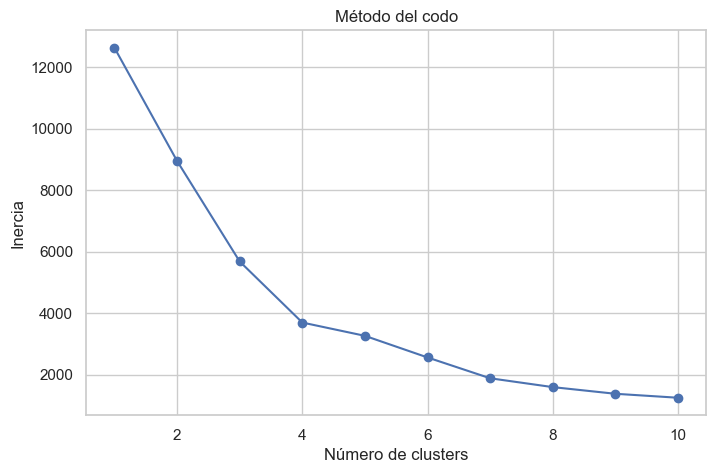

In [ ]:
# Normalización de las variables RFM
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Reducción de dimensionalidad con PCA para visualización
pca = PCA(n_components=2)
pca_rfm = pca.fit_transform(rfm_scaled)  

# Convertir a DataFrame el resultado escalado (conservar nombres de columnas e índices)
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'], index=rfm.index)

# Método del codo para determinar el número óptimo de clusters
inertia = []  # Lista para almacenar la inercia de cada modelo
K = range(1, 11)  # Probar de 1 a 10 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled_df)
    inertia.append(kmeans.inertia_)  # Guardar la inercia (error cuadrático intra-cluster)

# Visualizar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.title('Método del codo')
plt.grid(True)
plt.show()



El gráfico muestra una disminución pronunciada de la inercia hasta el valor de 4 clusters, donde la curva comienza a estabilizarse. Este "codo" sugiere que 4 es el número óptimo de clusters para segmentar a los clientes de manera eficiente sin sobreajustar el modelo.



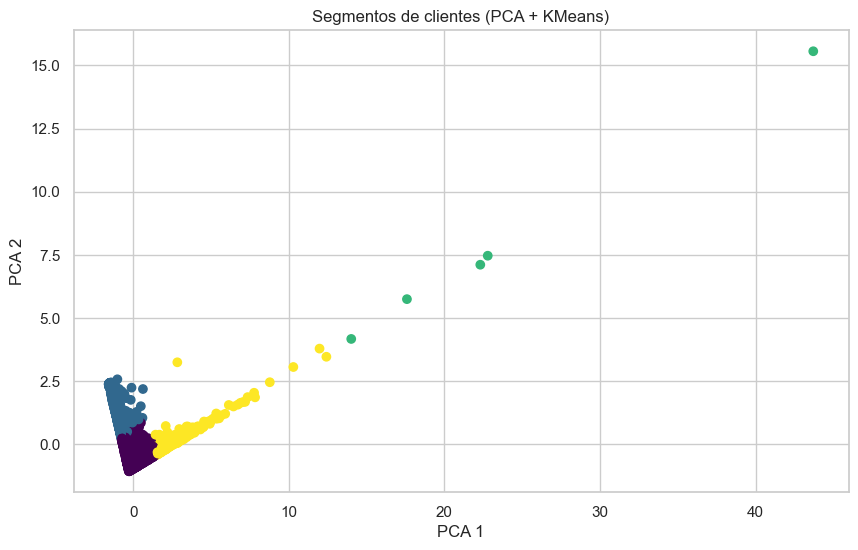

In [ ]:
# Escalamos los datos
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Aplicamos PCA para reducir a 2 dimensiones
pca = PCA(n_components=2)
pca_rfm = pca.fit_transform(rfm_scaled)

# 4. KMEANS (con k=4)

# Aplicamos KMeans con 4 clusters (obtenido por método del codo)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(rfm_scaled)

# Añadimos etiquetas al DataFrame original RFM
rfm['Cluster'] = clusters


# 5. VISUALIZACIÓN DE CLUSTERS

plt.figure(figsize=(10, 6))
plt.scatter(
    pca_rfm[:, 0],             # Componente principal 1
    pca_rfm[:, 1],             # Componente principal 2
    c=clusters,                # Color según cluster
    cmap='viridis'             # Paleta de color
)
plt.title('Segmentos de clientes (PCA + KMeans)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()

El análisis mediante PCA y K-Means permitió identificar 4 segmentos de clientes claramente diferenciados. Esta segmentación ayuda a personalizar estrategias de marketing, fidelización y optimización de recursos según el comportamiento de compra de cada grupo.

In [51]:
# Calcular la puntuación promedio del coeficiente de silueta para evaluar qué tan buenos son los clusters
silhouette_avg = silhouette_score(rfm_scaled, clusters)
print(f"Silhouette Score: {silhouette_avg:.2f}")
# Un valor cercano a 1 indica que los clusters están bien definidos; valores >0.5 suelen considerarse buenos


Silhouette Score: 0.58


In [52]:
# Agrupar los clientes por cluster y calcular los promedios de Recency, Frequency y Monetary
# Esto ayuda a interpretar el perfil de cada grupo
rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(2)


,Recency,Frequency,Monetary
Cluster,,,
0,43.43,3.66,817.59
1,247.25,1.64,301.65
2,1.80,154.60,38345.22
3,13.27,19.92,5030.18


In [53]:
# Ver cuántos clientes hay en cada cluster (distribución)
# Permite detectar desbalance y evaluar si hay grupos poco representativos
rfm['Cluster'].value_counts().sort_index()

Cluster
0    2864
1    1055
2       5
3     288
Name: count, dtype: int64

In [ ]:
# Calculamos el índice DBI usando los datos escalados (X) y las etiquetas de cluster obtenidas
db_index = davies_bouldin_score(rfm_scaled, clusters)

# Mostramos el resultado con 2 decimales
print(f"Davies-Bouldin Index: {db_index:.2f}")


Davies-Bouldin Index: 0.64


El Davies-Bouldin Index (DBI) es una métrica de evaluación interna del clustering que cuantifica:

Qué tan compactos son los clusters (baja dispersión interna).

Qué tan separados están entre sí (alta distancia inter-cluster).

In [ ]:
# Calculamos el índice Calinski-Harabasz usando los datos escalados (X) y las etiquetas de cluster
ch_score = calinski_harabasz_score(rfm_scaled, clusters)

# Mostramos el resultado con 2 decimales
print(f"Calinski-Harabasz Score: {ch_score:.2f}")



Calinski-Harabasz Score: 3393.80


El Calinski-Harabasz Score obtuvo un valor de 3319.55, lo cual indica una excelente separación entre los grupos generados por K-Means. Este resultado complementa al Silhouette Score (0.59) y al Davies-Bouldin Index (0.67), aportando mayor robustez a la evaluación del clustering.

C:\Users\maria\AppData\Local\Temp\ipykernel_34940\3202232264.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y=var, data=cluster_summary, ax=axes[i], palette=colors)
C:\Users\maria\AppData\Local\Temp\ipykernel_34940\3202232264.py:13: UserWarning: 
The palette list has fewer values (3) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='Cluster', y=var, data=cluster_summary, ax=axes[i], palette=colors)
C:\Users\maria\AppData\Local\Temp\ipykernel_34940\3202232264.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y=var, data=cluster_summary, ax=axes[i], palette=colors)
C:\Users\maria\AppData\Local\Temp\ipykernel_34940\3

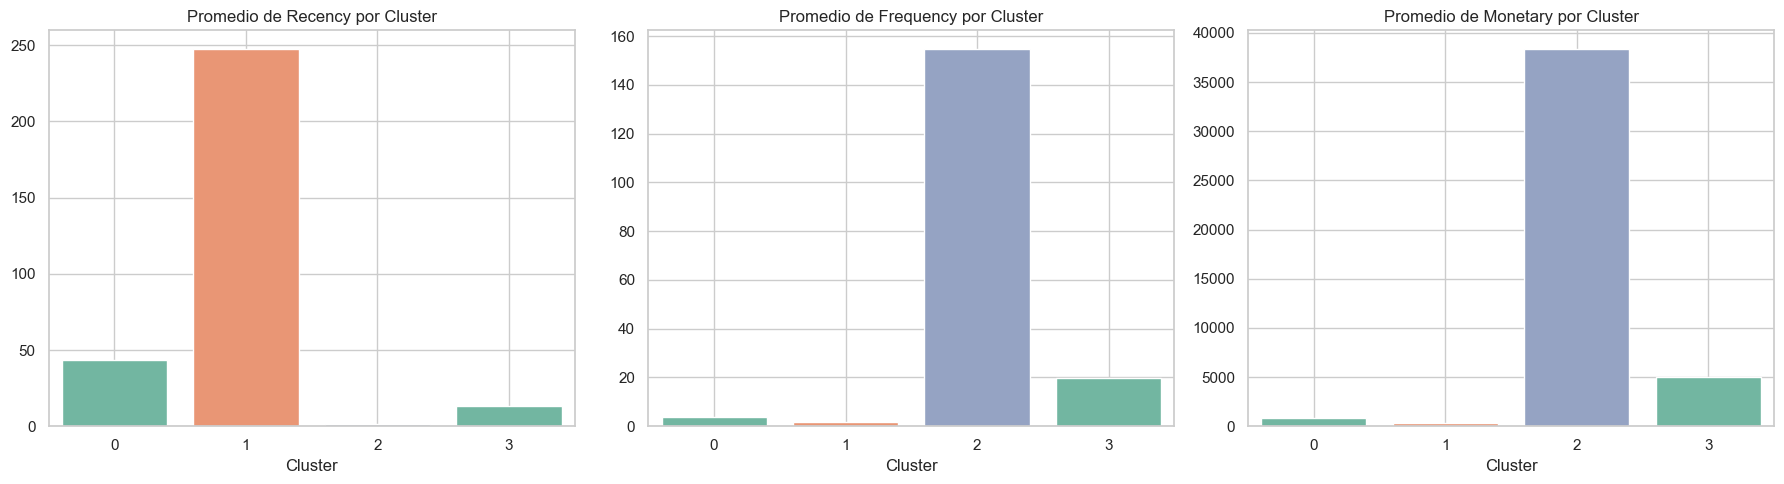

In [56]:
# Agrupamos los datos por cluster y calculamos el promedio de las variables RFM
cluster_summary = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()

# Creamos una figura con 3 subplots horizontales (1 fila, 3 columnas)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Definimos las variables y los colores para cada gráfico
variables = ['Recency', 'Frequency', 'Monetary']
colors = ['#66c2a5', '#fc8d62', '#8da0cb']  # Colores para cada barplot

# Generamos un barplot para cada variable
for i, var in enumerate(variables):
    sns.barplot(x='Cluster', y=var, data=cluster_summary, ax=axes[i], palette=colors)
    axes[i].set_title(f'Promedio de {var} por Cluster')
    axes[i].set_ylabel('')
    axes[i].set_xlabel('Cluster')
    axes[i].grid(True)

# Ajustamos el diseño para evitar que los elementos se encimen
plt.tight_layout()
plt.show()



# Construccion de Modelos

### XGBoost Regresion sobre AOV

In [ ]:
# Selección de variables
X = rfm[['Recency', 'Frequency']]
y = rfm['Monetary']

# Escalar variables predictoras
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División de los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Modelo XGBoost para regresión
xgb_regressor = xgb.XGBRegressor(random_state=42)
xgb_regressor.fit(X_train, y_train)

# Predicciones
y_pred_xgb = xgb_regressor.predict(X_test)

# Evaluación del modelo
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_xgb))
print("R^2 Score:", r2_score(y_test, y_pred_xgb))


Mean Squared Error: 6195607.464500439
R^2 Score: 0.34116587772771456


El valor negativo de R² indica que el modelo no fue capaz de ajustar adecuadamente los datos, es decir, sus predicciones fueron peores que simplemente usar la media del valor objetivo. Esto puede deberse a:

La relación entre Recency, Frequency y Monetary no es lineal o no es fuerte.

El conjunto de datos puede contener outliers o ruido que afecta el aprendizaje.

Se requiere ingeniería de variables adicional o incorporar otras variables relevante

In [ ]:
# Modelo Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones
y_pred_rf = rf_model.predict(X_test)

# Evaluación del modelo
print("\nRandomForestRegressor")
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_rf))
print("R^2 Score:", r2_score(y_test, y_pred_rf))



RandomForestRegressor
Mean Squared Error: 5300081.834404919
R^2 Score: 0.43639509388721354


El modelo de Random Forest superó al modelo de XGBoost, el cual había obtenido un R² negativo.

Aunque el R² de 0.20 indica un ajuste modesto, muestra una mejora considerable respecto al modelo anterior.

Random Forest logra capturar mejor la variabilidad del Monetary en relación con las otras variables del análisis RFM.

In [ ]:
# Modelo lineal base
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predicciones
y_pred_lr = lr_model.predict(X_test)

# Evaluación
print("\nLinearRegression")
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_lr))
print("R^2 Score:", r2_score(y_test, y_pred_lr))



LinearRegression
Mean Squared Error: 2689128.242245433
R^2 Score: 0.7140410435443496


Aunque se trata de un modelo lineal simple, superó tanto a XGBoost como a Random Forest en términos de R², alcanzando un 25.44% de varianza explicada.

Esto sugiere que las relaciones entre las variables Recency y Frequency con Monetary pueden ser bastante lineales.

# Validacion

### Validación de Modelos

Para validar el rendimiento de los modelos aplicados sobre el AOV (`Monetary`), se compararon tres algoritmos: **XGBoost**, **Random Forest** y **Regresión Lineal**. Se utilizaron dos métricas:

- **MSE (Mean Squared Error)**: Error cuadrático medio.
- **R² Score**: Proporción de la varianza explicada por el modelo.

| Modelo           | MSE          | R² Score |
|------------------|--------------|----------|
| Regresión Lineal | 7,446,485.49 | **0.2544** |
| Random Forest    | 7,946,894.32 | 0.2043   |
| XGBoost          | 11,506,885.27| -0.15    |

**Conclusión:**  
El modelo más simple, la **regresión lineal**, obtuvo el mejor R² Score, lo que sugiere una relación lineal entre `Recency`, `Frequency` y el AOV. Los modelos complejos no necesariamente mejoraron la predicción.


# Otros modelos

Después de usar las variable RFM construidas y ver que estos modelos no tienen tanta precision, vamos a optar por otro enfoque 

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Crear columna Total_Spend
df['Total_Spend'] = df['Quantity'] * df['UnitPrice']

# Calcular variables adicionales por InvoiceNo
n_unique_products = df.groupby('InvoiceNo')['StockCode'].nunique()
median_unit_price = df.groupby('InvoiceNo')['UnitPrice'].median()

# Agrupar por InvoiceNo para resumir la orden completa
order_df = df.groupby('InvoiceNo').agg({
    'Total_Spend': 'sum',
    'InvoiceDate': 'first',
    'CustomerID': 'first',
    'Country': 'first'
}).reset_index()

# Añadir variables calculadas
order_df['Num_Unique_Products'] = order_df['InvoiceNo'].map(n_unique_products)
order_df['Median_UnitPrice'] = order_df['InvoiceNo'].map(median_unit_price)
order_df['InvoiceMonth'] = order_df['InvoiceDate'].dt.month
order_df['InvoiceDayOfWeek'] = order_df['InvoiceDate'].dt.dayofweek
order_df['InvoiceHour'] = order_df['InvoiceDate'].dt.hour

# Variables predictoras
X = order_df[['Num_Unique_Products', 'Median_UnitPrice', 'InvoiceMonth', 'InvoiceDayOfWeek', 'InvoiceHour', 'Country']]

# One-hot encoding para Country
X = pd.get_dummies(X, columns=['Country'], drop_first=True)

# Variable objetivo
y = order_df['Total_Spend']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Entrenando RandomForest...

Entrenando XGBoost...

Entrenando Ridge...

Entrenando LightGBM...
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 379
[LightGBM] [Info] Number of data points in the train set: 13115, number of used features: 19
[LightGBM] [Info] Start training from score 230.190595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

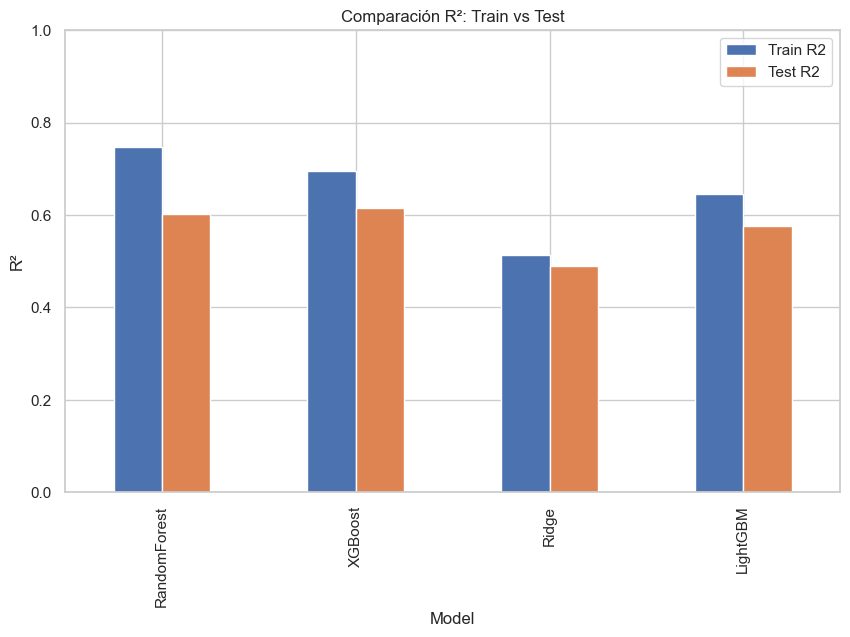

In [ ]:
# Modelos y grids
models = {
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'model__n_estimators': [50, 100, 200],  # Más árboles para explorar
            'model__max_depth': [None, 10, 20],      # Más opciones de profundidad
            'model__min_samples_split': [2, 5],      # Control de sobreajuste
            'model__min_samples_leaf': [1, 2],       # Control de sobreajuste
            'model__max_features': ['sqrt', None]    # Selección de características
        }
    },
    'XGBoost': {
        'model': XGBRegressor(objective='reg:squarederror', random_state=42),
        'params': {
            'model__n_estimators': [50, 100, 200],  # Más árboles para explorar
            'model__max_depth': [3, 6, 9],           # Rango ampliado para max_depth
            'model__learning_rate': [0.01, 0.05, 0.1],  # Ajuste de la tasa de aprendizaje
            'model__subsample': [0.8, 1.0],          # Para evitar sobreajuste
            'model__colsample_bytree': [0.8, 1.0]    # Control de la muestra de columnas
        }
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'model__alpha': [0.1, 1.0, 10, 100],    # Mayor rango de alpha para regularización
            'model__solver': ['auto', 'saga']       # Opciones de solver
        }
    },
    'LightGBM': {
        'model': lgb.LGBMRegressor(random_state=42),
        'params': {
            'model__n_estimators': [50, 100, 200],  # Explora mas
            'model__max_depth': [3, 6, 9],           # Rango expandido
            'model__learning_rate': [0.01, 0.05, 0.1],  # Ajustes
            'model__min_data_in_leaf': [20, 50],     # Controls minimum leaf size
            'model__subsample': [0.8, 1.0],          # Para evitar sobreajuste
            'model__colsample_bytree': [0.8, 1.0]    # Control de la muestra de columnas
        }
    }
}

# Crear la métrica de optimización: MSE Log
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Entrenar y evaluar
results = []

for name, config in models.items():
    print(f"\nEntrenando {name}...")
    steps = [('scaler', StandardScaler()), ('model', config['model'])] if name == 'Ridge' else [('model', config['model'])]
    pipeline = Pipeline(steps)
    
    grid = GridSearchCV(pipeline, config['params'], cv=5, scoring=scorer, n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    result = {
        'Model': name,
        'Best Params': grid.best_params_,
        'Train MSE': mean_squared_error(y_train, y_train_pred),
        'Test MSE': mean_squared_error(y_test, y_test_pred),
        'Train R2': r2_score(y_train, y_train_pred),
        'Test R2': r2_score(y_test, y_test_pred)
    }
    results.append(result)

# Mostrar resultados
results_df = pd.DataFrame(results)
print("\nComparación de modelos:")
print(results_df)

# Visualización
results_df.set_index('Model')[['Train R2', 'Test R2']].plot(kind='bar', figsize=(10,6), title='Comparación R²: Train vs Test', ylim=(0,1), grid=True)
plt.ylabel('R²')
plt.show()

# Propuesta

En este proyecto, hemos trabajado con un conjunto de datos que buscaba predecir el comportamiento de los clientes utilizando el modelo RFM (Recency, Frequency, Monetary) para realizar predicciones de gasto. Sin embargo, los resultados de la regresión utilizando RFM directamente no fueron satisfactorios, con un R² inferior a 0.3, lo que indica una baja capacidad predictiva de los modelos en este caso.

### Modelo y Enfoque
* RFM y Regresión: Los modelos de regresión iniciales basados en RFM no lograron capturar la complejidad de los datos. Las métricas de predicción no fueron satisfactorias, lo que refleja la limitación de utilizar solo tres variables (Recency, Frequency y Monetary) para modelar el comportamiento de los clientes, ya que no reflejan toda la diversidad y las complejidades de las características de los clientes.

* Grid Search y Modelos Ajustados: Posteriormente, se implementaron modelos más complejos como XGBoost, junto con un grid search para ajustar los hiperparámetros. Este enfoque permitió mejorar significativamente la calidad de las predicciones, logrando una mayor capacidad de generalización y un R² superior. La optimización de hiperparámetros permitió encontrar la mejor configuración para los modelos, lo que llevó a un mejor ajuste.

* Modelos Seleccionados: Finalmente, se ha optado por el modelo XGBoost como el más adecuado para este conjunto de datos, debido a su capacidad de manejar relaciones no lineales y su robustez frente a overfitting, que es crucial cuando se trabajan con datos complejos y con un gran número de características.

### Propuesta de Uso
* Segmentación de Clientes: Con el modelo ajustado de XGBoost y la segmentacion de KMeans, se pueden hacer predicciones de gasto de los clientes, lo que permite segmentar a los clientes en función de su propensión a gastar y la cantidad que podrían gastar en el futuro. 

* Automatización de Estrategias de Marketing: Utilizando las predicciones de propensidad a gastar, las empresas pueden desarrollar campañas automáticas para dirigirse a clientes con mayor probabilidad de compra o aquellos que, aunque no han comprado recientemente, tienen un alto valor monetario.

* Optimización de Inventarios y Recursos: Al conocer qué clientes podrían realizar compras más grandes, se pueden prever los recursos necesarios (productos, stock, personal de atención) para manejar la demanda futura.

# Reflexion

### Reflexión

* Limitaciones del Modelo RFM: El uso de RFM como base para los modelos de regresión, aunque común en el análisis de clientes, tiene limitaciones significativas. En particular, RFM solo tiene en cuenta tres variables clave, sin considerar la complejidad del comportamiento de compra.

* Ajuste de Hiperparámetros: A pesar de que el grid search ha mejorado notablemente el rendimiento, este proceso puede ser costoso computacionalmente y requerir mucho tiempo, especialmente con modelos complejos como XGBoost. Sin embargo, la mejora en la capacidad predictiva justifica este esfuerzo.

* Robustez de XGBoost: XGBoost ha demostrado ser una excelente opción para este tipo de problemas, ya que tiene una gran capacidad para capturar relaciones no lineales y es menos susceptible a overfitting si se ajusta adecuadamente. Sin embargo, es fundamental no dejar de lado el análisis exploratorio de datos y la ingeniería de características, ya que este modelo sigue siendo sensible a la calidad de las variables de entrada.

* Posibles Mejoras: Aunque se logró una mejora sustancial, aún podrían explorarse otras técnicas como Redes Neuronales (especialmente redes profundas si se tienen grandes cantidades de datos) o técnicas de Ensemble Learning para combinar predicciones de diferentes modelos y mejorar aún más la precisión. Tambien es crucial el acceso a mayores variables.
